#Importing the necessary libraries

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, sklearn, numpy as np, xgboost as xgb, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Reading the dataset [link](https://www.kaggle.com/arockiaselciaa/creditcardcsv)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/creditcard.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
print('Number of rows and columns:',df.shape)

Number of rows and columns: (284807, 31)


In [ ]:
# Verification of the existence of null or missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
# Variable type in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Statistical information about the variables
df.describe().round()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,94814.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,88.0,0.0
std,47488.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,250.0,0.0
min,0.0,-56.0,-73.0,-48.0,-6.0,-114.0,-26.0,-44.0,-73.0,-13.0,-25.0,-5.0,-19.0,-6.0,-19.0,-4.0,-14.0,-25.0,-9.0,-7.0,-54.0,-35.0,-11.0,-45.0,-3.0,-10.0,-3.0,-23.0,-15.0,0.0,0.0
25%,54202.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.0,-1.0,-1.0,-1.0,-0.0,-1.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,6.0,0.0
50%,84692.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,22.0,0.0
75%,139320.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,0.0
max,172792.0,2.0,22.0,9.0,17.0,35.0,73.0,121.0,20.0,16.0,24.0,12.0,8.0,7.0,11.0,9.0,17.0,9.0,5.0,6.0,39.0,27.0,11.0,23.0,5.0,8.0,4.0,32.0,34.0,25691.0,1.0


In [ ]:
# Statistical information in each class
print('Non Fraud:',round(df['Class'].value_counts()[0]/len(df)*100,2),'%')
print(round(df.Amount[df.Class == 0].describe(),2))
print('Fraud:',round(df['Class'].value_counts()[1]/len(df)*100,2),'%')
print(round(df.Amount[df.Class == 1].describe(),2))

Non Fraud: 99.83 %
count    284315.00
mean         88.29
std         250.11
min           0.00
25%           5.65
50%          22.00
75%          77.05
max       25691.16
Name: Amount, dtype: float64
Fraud: 0.17 %
count     492.00
mean      122.21
std       256.68
min         0.00
25%         1.00
50%         9.25
75%       105.89
max      2125.87
Name: Amount, dtype: float64


#Distribution of data

Non Fraud: 99.83 %
Fraud: 0.17 %


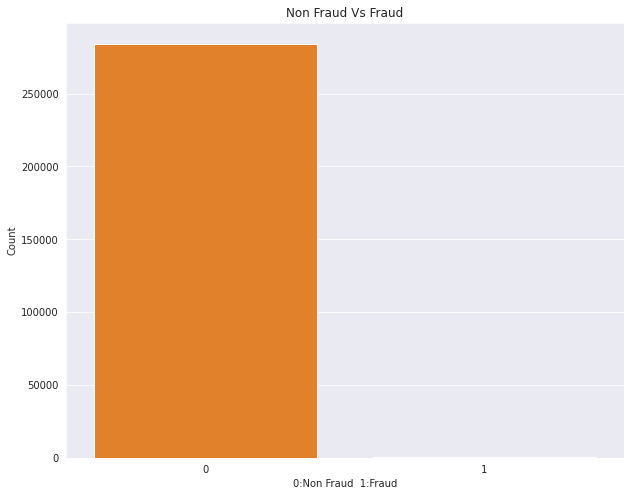

In [ ]:
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.barplot(x=df['Class'].value_counts().index,y=df['Class'].value_counts(), palette=["C1","C8"])
plt.title('Non Fraud Vs Fraud')
plt.ylabel('Count')
plt.xlabel('0:Non Fraud  1:Fraud')
print('Non Fraud:',round(df['Class'].value_counts()[0]/len(df)*100,2),'%')
print('Fraud:',round(df['Class'].value_counts()[1]/len(df)*100,2),'%');

we can see that out of 284,807 transactions, 284,315 were labelled as normal (99.83%) and only 492 were labelled as fraud (0.17%). Althought the fraud transactions are small, each transaction can represent very significant expense, which together can represent billions of dollars of lost revenue each year.

In [ ]:
#Separation of input variables from target variable
feature_names=df.iloc[:,1:30].columns
target=df.iloc[:1,30:].columns
data_features=df[feature_names]
data_target=df[target]
print("feature names:",feature_names)
print("target:",target)

feature names: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
target: Index(['Class'], dtype='object')


# Building the model

With the dataset defined, separating the input variables from the target variable, we divided the data into training and test sets by importing the train_test_split function.
The train_test_split function uses a randomizer to separate data into training and test sets. In this case, 70% of the data for training and 30% for tests were defined.
The random seed is used to ensure that the same data is used for all runs.

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train,X_test,y_train,y_test=train_test_split(data_features,data_target,train_size=0.70,test_size=0.30,random_state=1)

In [ ]:
#Building and training the XGBoost Model
xg=xgb.XGBClassifier()
xg.fit(X_train,y_train)

XGBClassifier()

In [ ]:
pip install scikit-plot

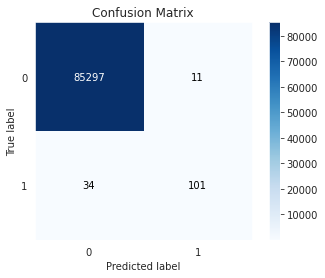

In [ ]:
#Classification Report - Model performance measures
def RunModel(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train.values.ravel())
    pred=model.predict(X_test)
    matrix=confusion_matrix(y_test,pred)
    return matrix,pred
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
import scikitplot as skplt
cmat,pred=RunModel(xg,X_train,y_train,X_test,y_test)
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test,pred)

In [ ]:
print("Accuracy:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 0.9994733330992591
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85308
           1       0.90      0.75      0.82       135

    accuracy                           1.00     85443
   macro avg       0.95      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



Although the accuracy was excellent, the algorithm wrongly classified some fraudulent transactions. Accuracy in a highly unbalanced dataset does not represent a correct value for the efficiency of a model. Initially, a method should be applied to balance the data before taking into account any performance evaluation metrics.

#Applying undersampling technique

In [ ]:
fraud_records=len(df[df.Class==1]) 
fraud_indices=df[df.Class==1].index
normal_indices=df[df.Class==0].index
# Randomly collect equal samples of each type
under_sample_indices=np.random.choice(normal_indices,fraud_records,False)
df_undersampled =df.iloc[np.concatenate([fraud_indices,under_sample_indices]),:]
X_undersampled=df_undersampled.iloc[:,1:30]
Y_undersampled=df_undersampled.Class
X_undersampled_train,X_undersampled_test,Y_undersampled_train,Y_undersampled_test=train_test_split(X_undersampled,Y_undersampled,test_size=0.30)

Non Fraud: 50.0 %
Fraud: 50.0 %


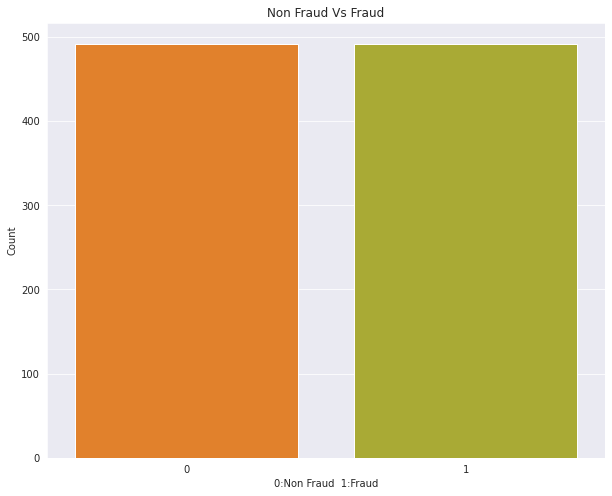

In [ ]:
# Distribution of data after undersampling
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.barplot(x=df_undersampled['Class'].value_counts().index,y=df_undersampled['Class'].value_counts(), palette=["C1","C8"])
plt.title('Non Fraud Vs Fraud')
plt.ylabel('Count')
plt.xlabel('0:Non Fraud  1:Fraud')
print('Non Fraud:',round(df_undersampled['Class'].value_counts()[0]/len(df_undersampled)*100,2),'%')
print('Fraud:',round(df_undersampled['Class'].value_counts()[1]/len(df_undersampled)*100,2),'%');

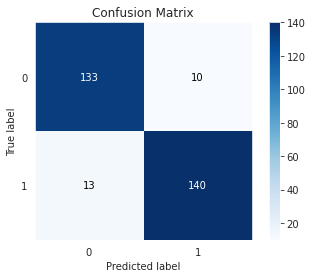

In [ ]:
#Using the "new" classifier for balanced data
xg_undersampled=xgb.XGBClassifier() 
cmat,pred=RunModel(xg_undersampled,X_undersampled_train,Y_undersampled_train,X_undersampled_test,Y_undersampled_test)
skplt.metrics.plot_confusion_matrix(Y_undersampled_test,pred)

In [ ]:
print("Accuracy:",accuracy_score(Y_undersampled_test,pred))
print(classification_report(Y_undersampled_test,pred))

Accuracy: 0.9222972972972973
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       143
           1       0.93      0.92      0.92       153

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



Accuracy has decreased, but sensitivity has greatly increased. Looking at the confusion matrix, we can see a much higher percentage of correct classifications of fraudulent data.
Unfortunately, a greater number of fraud classifications almost always means a correspondingly greater number of valid transactions also classified as fraudulent.

#Measurement of classifier performance 

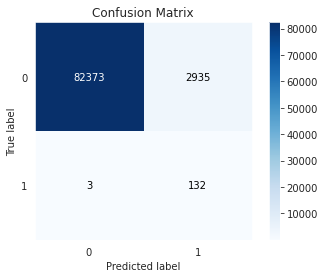

In [ ]:
#Using the "new" classifier for the original data test
xg=xgb.XGBClassifier() 
cmat,pred=RunModel(xg,X_undersampled_train,Y_undersampled_train,X_test,y_test)
skplt.metrics.plot_confusion_matrix(y_test,pred)

In [ ]:
print("Accuracy:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 0.9656145032360756
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85308
           1       0.04      0.98      0.08       135

    accuracy                           0.97     85443
   macro avg       0.52      0.97      0.53     85443
weighted avg       1.00      0.97      0.98     85443



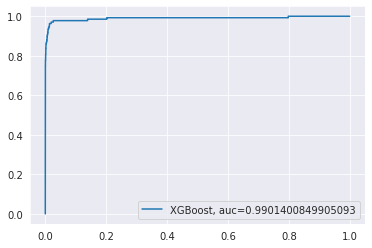

In [ ]:
# Measurement of classifier performance through the ROC and AUC curve
from sklearn import metrics
clf = xgb.XGBClassifier()
clf.fit(X_undersampled_train, Y_undersampled_train)
y_pred = clf.predict(X_test)
# AUC Curve XGBoost
y_pred_probability = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_probability)
auc = metrics.roc_auc_score(y_test, y_pred_probability)
plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Here, the model has a very good result, with AUC of 0.99.